Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0429 - mae: 0.1329 - val_loss: 0.0019 - val_mae: 0.0274
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0083 - mae: 0.0641 - val_loss: 0.0018 - val_mae: 0.0246
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0069 - mae: 0.0567 - val_loss: 0.0017 - val_mae: 0.0230
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0060 - mae: 0.0516 - val_loss: 0.0017 - val_mae: 0.0225
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0057 - mae: 0.0490 - val_loss: 0.0020 - val_mae: 0.0296
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0050 - mae: 0.0458 - val_loss: 0.0018 - val_mae: 0.0250
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0049 - mae: 0.0446 - val_loss: 0.0019 - val_mae: 0.0277
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0050 - mae: 0.0440 - val_loss: 0.0020 - val_mae: 0.0272
Epoch 9/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step -

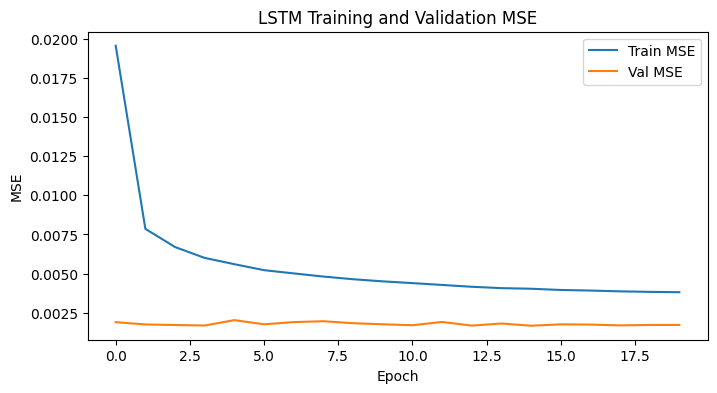

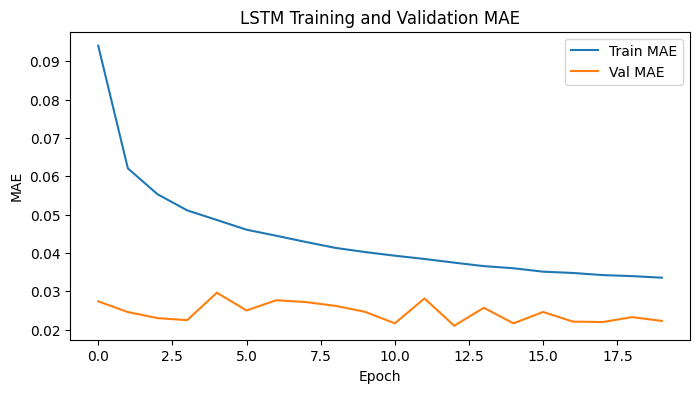

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== MSE Comparison ===
Model                        MSE
Random Forest           0.136754
Seq2Seq LSTM            0.001896


In [17]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 1) Load dataset
# files.upload()
df =pd.read_csv('Final Mesonet Dataset.csv')
features =['Temp_C','RH_2m','Pressure_1','WndSpd_2m']
df =df.dropna(subset=features)
data =df[features].values

# -------------------------------
# 2) Random Forest  scaled MSE
# -------------------------------
w_rf = 6
X_rf, y_rf =[], []
for i in range(len(data) - w_rf):
    X_rf.append(data[i:i+w_rf].flatten())
    y_rf.append(data[i+w_rf])
X_rf, y_rf = np.array(X_rf), np.array(y_rf)

split_rf =int(len(X_rf)*0.8)
X_rf_tr, X_rf_te =X_rf[:split_rf], X_rf[split_rf:]
y_rf_tr, y_rf_te = y_rf[:split_rf], y_rf[split_rf:]

scaler_X_rf =StandardScaler().fit(X_rf_tr)
scaler_y_rf =StandardScaler().fit(y_rf_tr)
X_rf_tr_s =scaler_X_rf.transform(X_rf_tr)
X_rf_te_s =scaler_X_rf.transform(X_rf_te)
y_rf_tr_s =scaler_y_rf.transform(y_rf_tr)
y_rf_te_s =scaler_y_rf.transform(y_rf_te)

rf_scaled =MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_scaled.fit(X_rf_tr_s, y_rf_tr_s)
y_rf_pred_s =rf_scaled.predict(X_rf_te_s)

mse_rf_scaled = mean_squared_error(y_rf_te_s, y_rf_pred_s)

# -------------------------------
# 3) scaled MSE + training plots
# -------------------------------
# MinMax scale for LSTM
scaler_mm = MinMaxScaler()
data_mm = scaler_mm.fit_transform(data)

w_ls, horizon= 12, 4
X_ls, y_ls= [], []
for i in range(len(data_mm) - w_ls - horizon + 1):
    X_ls.append(data_mm[i:i+w_ls])
    y_ls.append(data_mm[i+w_ls:i+w_ls+horizon, :4])
X_ls, y_ls = np.array(X_ls), np.array(y_ls)

split_ls = int(len(X_ls) * 0.8)
X_train, X_test = X_ls[:split_ls], X_ls[split_ls:]
y_train, y_test = y_ls[:split_ls], y_ls[split_ls:]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(w_ls, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(horizon * len(features))
])
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])

history = model.fit(
    X_train,
    y_train.reshape(-1, horizon * len(features)),
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Plot Training & Validation MSE
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('LSTM Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plot Training & Validation MAE
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('LSTM Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Compute scaled MSE on test set
y_pred_s = model.predict(X_test)
y_test_flat = y_test.reshape(-1, horizon * len(features))
mse_lstm_scaled = mean_squared_error(y_test_flat, y_pred_s)

# 4) Display
print("\n=== MSE Comparison ===")
print(f"{'Model':<20}{'MSE':>12}")
print(f"{'Random Forest':<20}{mse_rf_scaled:12.6f}")
print(f"{'Seq2Seq LSTM':<20}{mse_lstm_scaled:12.6f}")


In [15]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 12, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,634 (1.36 MB)

 Trainable params: 118,544 (463.06 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,090 (926.14 KB)